# Implementazione del task 4 - Feature Reduction

Avendo completato il task 3, possiamo ora presumere che tutti i dataframe che stiamo considerando siano nella forma $E\subseteq \mathbb{T}\times \mathbb{R}^m \times \mathbb{L}^n$. Tuttavia, potremmo avere cardinalità troppo grandi e proprio per questo motivo vorremmo quindi ridurre la varietà di eventi possibili implementando ad esempio una tecnica di clustering per raggruppare i dati in collezioni di campioni sulla base di una loro similarità.

In [1]:
# IMPORT
import nbimporter
import ETLBasics_t1 as task1
import ProfilingBasics_t2 as task2
import TimeSeriesToEvents_t3 as task3
import dateutil as du
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial import distance
from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture
import warnings
warnings.simplefilter("ignore", UserWarning)

In [2]:
# VARIABILI
PATH = './pmdata/'
people = [1,2,3]

In [10]:
# IPER-PARAMETRI

# raggruppamento task 3
K_GROUP_DAY = 1
K_GROUP_HOUR = 1

### Implementazione del task 1

In [3]:
sedentary_minutes = task1.sedentary_minutes_to_df(PATH, people)
sleep_0, sleep_1 = task1.sleep_to_df(PATH, people)
exercise_0, exercise_1 = task1.exercise_to_df(PATH, people)
lightly_active_minutes = task1.lightly_active_minutes_to_df(PATH, people)
time_in_heart_rate_zones = task1.time_in_heart_rate_zones_to_df(PATH, people)
moderately_active_minutes = task1.moderately_active_minutes_to_df(PATH, people)
very_active_minutes = task1.very_active_minutes_to_df(PATH, people)
resting_heart_rate = task1.resting_heart_rate_to_df(PATH, people)
srpe = task1.srpe_to_df(PATH, people)
wellness = task1.wellness_to_df(PATH, people)
injury = task1.injury_to_df(PATH, people)

try:
    steps = pd.read_pickle("dataframes/steps.pkl").loc[people]
    distance = pd.read_pickle("dataframes/distance.pkl").loc[people]
    calories = pd.read_pickle("dataframes/calories.pkl").loc[people]
    heart_rate = pd.read_pickle("dataframes/heart_rate.pkl").loc[people]
except:
    steps = task1.steps_to_df(PATH, people)
    distance = task1.distance_to_df(PATH, people)
    calories = task1.calories_to_df(PATH, people)
    heart_rate = task1.heart_rate_to_df(PATH, people)

### Definiamo delle variabili in modo da raggruppare i dataframe in base al tipo di dato e all'aggregazione

In [4]:
group_time_series_map = {
    'DAY':  [sedentary_minutes,lightly_active_minutes,moderately_active_minutes,very_active_minutes,resting_heart_rate,time_in_heart_rate_zones],
    'HOUR': [calories]  #,distance,heart_rate,steps
}
event_name = [exercise_0,exercise_1]  #,sleep_0,sleep_1,srpe,wellness,injury

## Clustering con K-means

A partire da una clusterizzazione iniziale (il numero di cluster deve essere fissato
a priori), l'algoritmo K-means assegna ad ogni iterazione tutti i punti al cluster
con la similarità più vicina e poi aggiorna tali similarità, terminando nel caso in cui sia
giunto a convergenza. Questo algoritmo ha un'efficienza lineare nella dimensione
del dataset, perciò risulta ottimo per grandi insiemi di dati.

Quindi, a partire da coppie del tipo $(mean,std)$ possiamo applicare l'algoritmo K-means per ridurre il numero di tali coppie. Inoltre, si può anche considerare di normalizzarne i valori in quanto rappresentano due misure diverse.

### Elbow method

È un'euristica, utilizzata nell'analisi dei cluster, che serve per determinare automaticamente il miglior numero di cluster. Il metodo consiste nel cercare il punto di inflessione nel grafico dell'errore in funzione del numero di cluster e selezionare tale punto della curva come numero di cluster da utilizzare.

È possibile poi utilizzare diversi criteri di clustering per valutare il grado di ottimalità di ogni soluzione trovata ed evitare così l'overfitting.

In [5]:
# FUNZIONI (per i criteri di clustering)
def minimizzazione_distanze_dai_centroidi(kmeans, points):
    '''
    Minimizza la somma dei quadrati delle distanze dei pattern x dai centroidi.
    È un buon criterio per cluster a simmetria radiale (i.e., circolari), ma penalizza forme allungate o cluster innestati
    '''
    predictions = kmeans.predict(points)
    cluster_centers = kmeans.cluster_centers_
    points_center = [ cluster_centers[i] for i in predictions ]
    error = sum([np.linalg.norm(np.array(points[i])-np.array(points_center[i]))**2 for i in range(len(points))])
    return error/len(points)


def minimizzazione_distanze_intra_classe(kmeans, points):
    '''
    Non penalizza cluster allungati.

    NOTA: $ è la relazione di appartenenza
    Je = \sum{su tutti i cluster}{n_i/N * s_i}
    s_i = sum{x $ C_i}{fs(x, C_i)}
    
    con n_i che sono gli elementi dentro un cluster.
    fs può essere fs(x,C_i) = min{x' $ C_i}{x' != x} || x - x'||^2

    '''

    predictions = kmeans.predict(points)
    
    cluster_centers = kmeans.cluster_centers_
    clusters = [list(np.array(points)[np.where(predictions == i)]) for i in range(len(cluster_centers))]

    # 1/n_i * ( min{x' $ C_i}{x' != x} || x - x'||^2 )
    fs = [(len( clusters[predictions[j]]) / len(points)) * min([np.linalg.norm(np.array(point_j_1)-np.array(points[j]))**2 \
                if points[j]!=list(point_j_1) else float("inf") \
                for point_j_1 in clusters[predictions[j]] ]) for j in range(len(points))]
    Je = sum(fs)
    return Je

def bic(kmeans, points):
    '''
    Calcola la metrica bic=k*ln(n) - 2*ln(L) con:
        - k numero di parametri del modello (k del kmeans * d dimensionalità delle medie)
        - n numero di campioni del dataset
        - L la logLikelihood del modello. In questo caso per calcolarla uso l'algoritmo di Expectation Maximization
          inizializzato nello stesso modo del k-means.
    '''
    # numero di cluster
    k = len(kmeans.cluster_centers_)
    # numero di campioni e dimesione di ciascuno di essi
    N, d = np.array(points).shape

    gmm = GaussianMixture(n_components=k, covariance_type='spherical', tol=1e-5, random_state=0)
    gmm.fit(points)
    return k * d * np.log(N) - 2*sum(gmm.score_samples(points))


In [6]:
# FUNZIONI (per l'algoritmo di clustering)
def extract_mean_std_columns_from_df(df):
    '''
    Estraggo i nomi delle colonne che hanno come sottostringa _std o _mean.
    Poi si ritorna i nomi di quelle colonne
    '''
    col_names = list(df.columns)
    original_attr_names = []
    visited = []
    for name in col_names:
        if '_mean' in name or '_std' in name:
            tmp = name.split("_mean")[0]
            tmp = tmp.split("_std")[0]

            # tengo solo 1 copia del nome delle colonne originarie
            if tmp not in visited:
                # ritorno una coppia col secondo elemento che è una lista cosi' da utilizzarlo
                # per fare la selezione delle colonne nel dataframe.
                original_attr_names.append((tmp, [tmp+"_mean", tmp+"_std"]))
                visited.append(tmp)

    return original_attr_names

def kmeans_discretization(df, is_event=False, want_normalize=False, ignore_cardinalities=False, fn_minimize=minimizzazione_distanze_dai_centroidi, show_plot=False, min_num_of_cluster=1, max_num_of_cluster=20):
    '''
    La funzione a partire da un dataframe va a discretizzare i suoi attributi continui. Per la discretizzazione viene usato
    il kmeans e per la scelta del k si usa una ricerca che minimizza la metrica 'fn_minimize'. 
    '''
    df = df.copy()
    # recuperiamo le colonne continue degli eventi o delle serie temporali trasformate in eventi
    cols = task2.get_continuous_attributes(df) if is_event else extract_mean_std_columns_from_df(df)

    for element in cols:
        if is_event: # element è solo il nome della colonna
            attribute_sel = original_col_name= element
        else: # element è della forma: (nome_colonna, [nome_colonna_mean, nome_colonna_std])
            original_col_name = element[0]
            attribute_sel = element[1] # lista con [nome_colonna_mean, nome_colonna_std]
        
        if want_normalize:
            df[attribute_sel] = task2.min_max_norm(df[attribute_sel]) # Di default sostituisce i NaN con 1

        points = df.loc[:, ([attribute_sel] if is_event else attribute_sel)].values.tolist()
        points = list(set(points)) if ignore_cardinalities else points

        # ricerca del miglior K minimizzando la metrica 'fn_minimize'
        y = []
        for i in range(min_num_of_cluster, max_num_of_cluster+1):
            try:
                kmeans = KMeans(n_clusters=i, random_state=0).fit(points)
                y.append(fn_minimize(kmeans, points))
            except:
                y.append(float("inf"))

        best_k = y.index(min(y)) + min_num_of_cluster # min(y) calcola il minimo nella lista e poi determina il valore di k

        if show_plot:
            plt.title("Metric value for " + original_col_name); plt.xlabel("k"); plt.ylabel("Metric value") 
            plt.plot(range(min_num_of_cluster, max_num_of_cluster+1),y) 
            plt.show()   

        kmeans = KMeans(n_clusters=best_k, random_state=0).fit(points)
        # cluster_indexes e cluster_centers verranno usati per costruire due colonne nel dataframe che sostituiranno
        # la/e colonna/e in attribute_sel.
        cluster_indexes = kmeans.predict(points)
        cluster_centers =  kmeans.cluster_centers_

        if show_plot:
            plt.title(f"{original_col_name} - k={best_k}")
            if is_event:
                plt.xlabel("value")
                plt.scatter([i for i in points], [0 for i in points], c = list(cluster_indexes))
            else:
                plt.ylabel("std"); plt.xlabel("mean")
                plt.scatter([i[0] for i in points], [i[1] for i in points], c = list(cluster_indexes))
            plt.show()

        if is_event: # nel caso di un evento i centri dei cluster sono 1-dim
            cluster_centers = [round(x[0],2) for x in cluster_centers]
            df = df.drop(labels=attribute_sel, axis=1)
        
        else: # nel caso di un serie temporali i centri dei cluster sono a 2-dim (1 per la media, 1 per std)
            cluster_centers = [[round(x[0],2), round(x[1],2)] for x in cluster_centers]
            # adesso si possono eliminare le colonne
            df = df.drop(labels=attribute_sel[0], axis=1)
            df = df.drop(labels=attribute_sel[1], axis=1)
        
        df[original_col_name + '_cluster_index'] = cluster_indexes
        df[original_col_name + '_cluster_center'] = [ cluster_centers[i] for i in cluster_indexes ]

    return df

### Implementazione dei task 3 e 4

In [7]:
day_kmeans_data = []
hour_kmeans_data = []
event_kmeans_data = []

for df in group_time_series_map['DAY']:
    df = task3.from_ts_to_event_based_data(df,'DAY', K_GROUP_DAY) # questo andrà ad aggiungere per ogni colonna numerica _mean e _std
    df = kmeans_discretization(df)
    day_kmeans_data.append(df)

for df in group_time_series_map['HOUR']:
    df = task3.from_ts_to_event_based_data(df,'HOUR', K_GROUP_HOUR)
    df = kmeans_discretization(df)
    hour_kmeans_data.append(df)


for event in event_name:
    event = kmeans_discretization(event, is_event=True)
    # estraggo le colonna TS per utilizzare la procedura che crea le transazioni
    # Viene estratto dall'indice TS e viene creata la corrispondente colonna TS
    event = event.reset_index(level='TS')
    event_kmeans_data.append(event)

## Esempi

In [8]:
df = time_in_heart_rate_zones#exercise_0#exercise_1#calories#lightly_active_minutes#

df_agg = df
if task3.is_ts(df):
    df_agg = task3.from_ts_to_event_based_data(df)

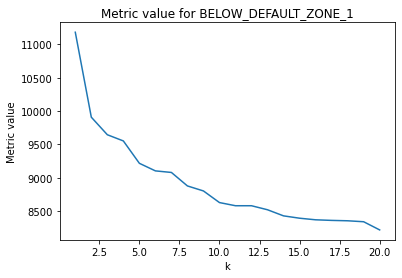

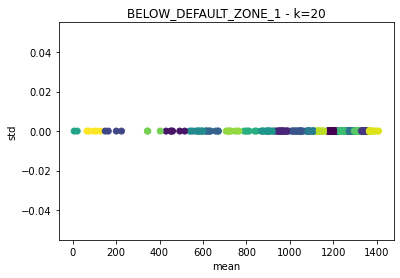

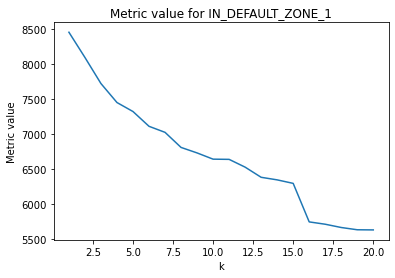

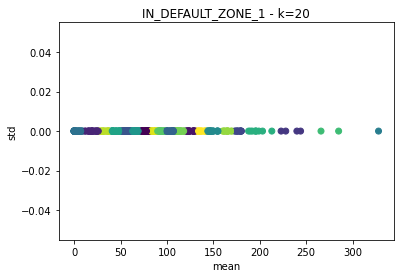

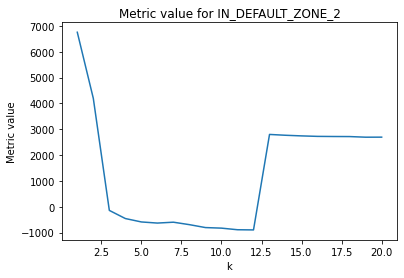

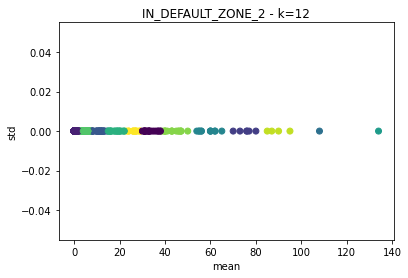

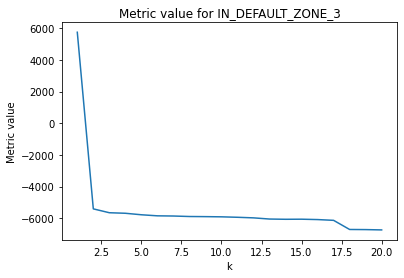

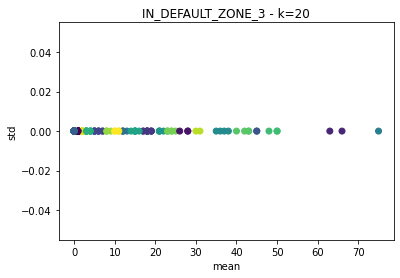

,HOUR,hour,half_day,eight_part_day,week_day,weekend,BELOW_DEFAULT_ZONE_1_cluster_index,BELOW_DEFAULT_ZONE_1_cluster_center,IN_DEFAULT_ZONE_1_cluster_index,IN_DEFAULT_ZONE_1_cluster_center,IN_DEFAULT_ZONE_2_cluster_index,IN_DEFAULT_ZONE_2_cluster_center,IN_DEFAULT_ZONE_3_cluster_index,IN_DEFAULT_ZONE_3_cluster_center
p_id,,,,,,,,,,,,,,
1,2019-11-01 00,0,0,0,Friday,False,13,"[1241.44, 0.0]",16,"[164.58, 0.0]",8,"[4.65, 0.0]",6,"[-0.0, 0.0]"
1,2019-11-02 00,0,0,0,Saturday,True,7,"[1273.72, 0.0]",19,"[136.79, 0.0]",1,"[0.51, 0.0]",6,"[-0.0, 0.0]"
1,2019-11-03 00,0,0,0,Sunday,True,13,"[1241.44, 0.0]",19,"[136.79, 0.0]",1,"[0.51, 0.0]",6,"[-0.0, 0.0]"
1,2019-11-04 00,0,0,0,Monday,False,14,"[1307.8, 0.0]",6,"[103.93, 0.0]",1,"[0.51, 0.0]",6,"[-0.0, 0.0]"
1,2019-11-05 00,0,0,0,Tuesday,False,14,"[1307.8, 0.0]",14,"[93.91, 0.0]",8,"[4.65, 0.0]",7,"[12.25, 0.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,2020-03-26 00,0,0,0,Thursday,False,16,"[732.25, 0.0]",7,"[2.25, 0.0]",1,"[0.51, 0.0]",6,"[-0.0, 0.0]"
3,2020-03-27 00,0,0,0,Friday,False,0,"[1193.91, 0.0]",2,"[19.57, 0.0]",1,"[0.51, 0.0]",6,"[-0.0, 0.0]"
3,2020-03-29 00,0,0,0,Sunday,True,2,"[963.42, 0.0]",7,"[2.25, 0.0]",1,"[0.51, 0.0]",6,"[-0.0, 0.0]"


In [9]:
kmeans_discretization(df_agg, is_event=(not task3.is_ts(df)), want_normalize=False, show_plot=True, fn_minimize=bic)